# Import necessary packages

In [1]:
import pandas
import numpy
import retl
import pathlib
import matplotlib.pyplot as plt
import helper
import scipy.stats

# Data split GFP assay

In [2]:
dp_run = pathlib.Path('8X4PF4')
dp_results = pathlib.Path(f'{dp_run.name}_Results')
dp_results.mkdir(exist_ok=True)

data = []
time = []
t0 = None
i = 0
while True:
    i += 1
    fp_output = pathlib.Path(dp_run, f'read_{i+1:02d}', 'Output.xml')
    if not fp_output.exists():
        break
    rdata = retl.parse(fp_output)
    df = rdata['Label1_Copy1_Copy1'].value
    time_end = rdata['Label1_Copy1_Copy1'].end_utc
    if not t0:
        t0 = time_end
    runtime = (time_end-t0).seconds/3600
    data.append(df)
    time.append(runtime)
merged_outputs = pandas.concat(data, ignore_index = True)

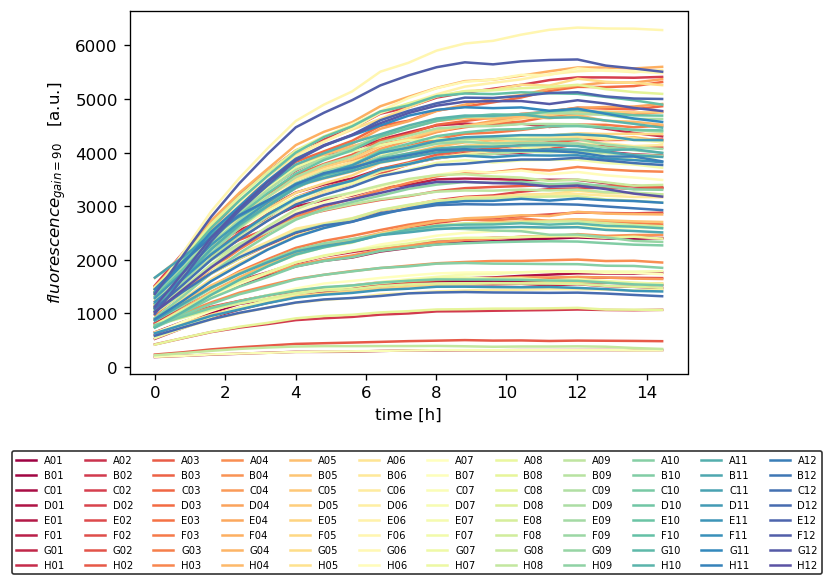

In [3]:
wells = []
for z in range(1, 13):
    z = f'{z:02}'
    well_rows = [f'{r}{z}' for r in 'ABCDEFGH']
    for w in well_rows:
        well = w
        wells.append(str(well))

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=120, sharex=True)

for w, well in enumerate(wells):
    color = plt.cm.Spectral(w/len(wells))
    ax.plot(time, merged_outputs[well], color = color, label = well)

ax.set_xlabel('time [h]')
ax.set_ylabel('$fluorescence_{gain=90}$   [a.u.]')
ax.legend(ncol=12, edgecolor='black', prop={'size':6}, bbox_to_anchor=(1.25,-0.2))
plt.show()

### Summarize from the last 3 cycles

In [4]:
df_events = pandas.read_excel(
    pathlib.Path(dp_run, 'eventlog.xlsx'),
    sheet_name='samplings',
    index_col=0
).set_index('well')
df_events['assay_wells'] = [
    f'{swell},{swell[0]}{int(swell[1:])+6:02d}'
    for swell in df_events.supernatant_well
]
assert 'A01,A07' in set(df_events.assay_wells)
df_events.sort_index(inplace=True)
df_events.head()

,timestamp,time,cycle,volume,supernatant_well,assay_wells
well,,,,,,
A01,2020-07-21T08:10:04.721Z,13.076466,61,-950,H01,"H01,H07"
A02,2020-07-21T07:05:04.299Z,11.993016,56,-950,G01,"G01,G07"
A03,2020-07-21T08:10:04.786Z,13.076485,61,-950,F01,"F01,F07"
A04,2020-07-21T08:10:04.841Z,13.076500,61,-950,E01,"E01,E07"
A05,2020-07-21T06:26:17.384Z,11.346651,53,-950,D01,"D01,D07"


In [5]:
df_sgfp = pandas.DataFrame(
    index=df_events.index,
)
for well in df_events.index:
    assay_wells = df_events.loc[well, 'assay_wells'].split(',')
    df_sgfp.loc[well, 'fluorescence_mean'] = merged_outputs[assay_wells].iloc[-3:].values.mean()
    df_sgfp.loc[well, 'fluorescence_std'] = merged_outputs[assay_wells].iloc[-3:].values.std()
    df_sgfp.loc[well, 'fluorescence_sem'] = scipy.stats.sem(merged_outputs[assay_wells].iloc[-3:].values.flatten())
df_sgfp.to_excel(pathlib.Path(dp_results, 'amount.xlsx'))
df_sgfp.head()

,fluorescence_mean,fluorescence_std,fluorescence_sem
well,,,
A01,4143.000000,235.314683,105.235925
A02,1534.500000,46.334832,20.721567
A03,3575.166667,196.716731,87.974397
A04,4108.666667,135.460531,60.579791
A05,1767.166667,17.938940,8.022538


# Data cutinase assay vs. sGFP

In [6]:
df_cutinase = pandas.read_excel(pathlib.Path(dp_results, 'activity.xlsx'), index_col='well')
df_cutinase.head()

,vmax_mean,vmax_hdi_3%,vmax_hdi_97%
well,,,
A01,2.988552,2.768288,3.202110
A02,0.683380,0.476446,0.861842
A03,1.888099,1.666430,2.088952
A04,2.360913,2.121860,2.588482
A05,1.055207,0.870872,1.244021


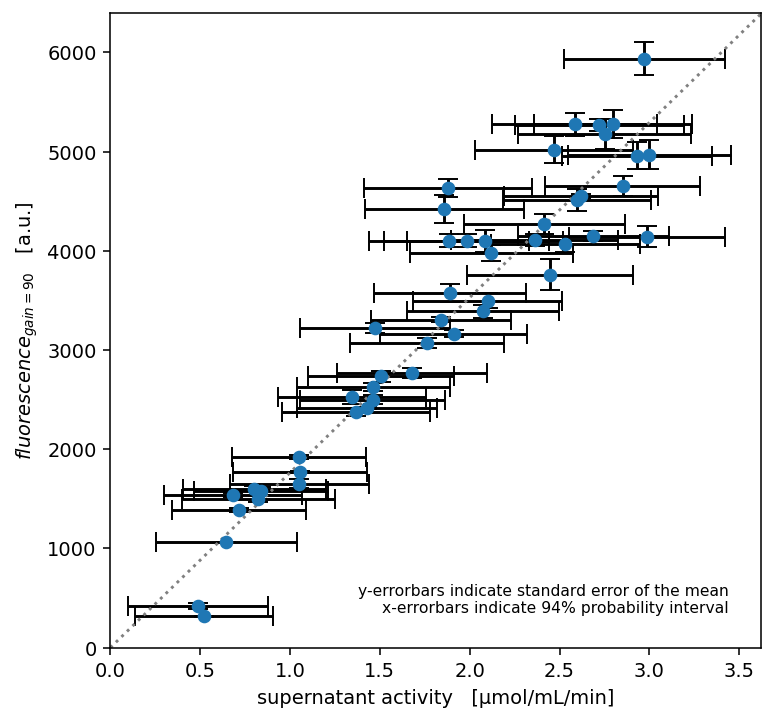

In [7]:
fig, ax = plt.subplots(dpi=140, figsize=(6, 6))

ax.errorbar(
    df_cutinase.vmax_mean,
    df_sgfp.fluorescence_mean,
    xerr=df_cutinase['vmax_hdi_97%'] - df_cutinase['vmax_hdi_3%'],
    yerr=df_sgfp['fluorescence_sem'],
    fmt='o', capsize=5, ecolor= 'black'
)
ax.set_xlim(0)
ax.set_ylim(0)
ax.plot(ax.get_xlim(), ax.get_ylim(), linestyle=':', color='gray')
ax.set_xlabel('supernatant activity   [µmol/mL/min]')
ax.set_ylabel('$fluorescence_{gain=90}$   [a.u.]')
ax.annotate(
    s='y-errorbars indicate standard error of the mean\nx-errorbars indicate 94% probability interval',
    xy=(0.95, 0.05),
    xycoords='axes fraction',
    horizontalalignment='right',
    verticalalignment='bottom',
    fontsize=8,
)
plt.show()